# Text Classification: Classical ML, RNN, and CNN
## NLP at AIMS South Africa 2025
### Based on Lecture 05: Sequence Modeling

This notebook demonstrates sentiment classification using three approaches:
1. **Classical ML** (baseline for comparison)
2. **Recurrent Neural Networks (RNN/LSTM)**
3. **Convolutional Neural Networks (CNN)**

**Dataset**: HausaNLP/AfriSenti-Twitter (Sentiment analysis on African languages)

## 1. Setup and Data Loading

In [1]:
# Install required packages
!pip install datasets torch scikit-learn pandas numpy matplotlib seaborn torchtext -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


In [2]:
# Load AfriSenti-Twitter dataset directly from GitHub
# Note: HuggingFace no longer supports dataset scripts, so we load directly from the repository

LANG = 'hau'  # Hausa language
BASE_URL = f"https://raw.githubusercontent.com/afrisenti-semeval/afrisent-semeval-2023/main/data/{LANG}"

# Load the data using pandas
train_df = pd.read_csv(f"{BASE_URL}/train.tsv", sep='\t')
val_df = pd.read_csv(f"{BASE_URL}/dev.tsv", sep='\t')
test_df = pd.read_csv(f"{BASE_URL}/test.tsv", sep='\t')

print("Dataset loaded successfully!")
print(f"\nTraining set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("\nColumns:", train_df.columns.tolist())
print("\nSample from training set:")
print(train_df.head(3))

Dataset loaded successfully!

Training set shape: (14172, 2)
Validation set shape: (2677, 2)
Test set shape: (5303, 2)

Columns: ['tweet', 'label']

Sample from training set:
                                               tweet     label
0  @user Da kudin da Arewa babu wani abin azo aga...  negative
1  @user Kaga wani Adu ar Banda💔😭 wai a haka Shi ...  negative
2  @user Sai haquri fa yan madrid daman kunce cha...  negative


In [3]:
# Extract texts and labels
train_texts = train_df['tweet'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['tweet'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['tweet'].tolist()
test_labels = test_df['label'].tolist()

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

# Check label distribution
label_names = ['positive', 'neutral', 'negative']
print("\nLabel distribution in training set:")
for i, name in enumerate(label_names):
    count = train_labels.count(name)
    print(f"{name}: {count} ({count/len(train_labels)*100:.1f}%)")

Training samples: 14172
Validation samples: 2677
Test samples: 5303

Label distribution in training set:
positive: 4687 (33.1%)
neutral: 4912 (34.7%)
negative: 4573 (32.3%)


## 2. Classical Machine Learning (Baseline)

**Why Classical ML?**
- Fast to train
- Interpretable
- Good baseline for comparison

**Limitation**: Treats text as bag-of-words (ignores word order and context)

We'll use TF-IDF features with three classifiers:
- Logistic Regression
- Naive Bayes
- Linear SVM

In [4]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

print(f"TF-IDF feature matrix shape: {X_train.shape}")

TF-IDF feature matrix shape: (14172, 5000)


In [5]:
# Train and evaluate classical ML models
classical_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42, max_iter=1000)
}

classical_results = {}

for name, model in classical_models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    classical_results[name] = accuracy

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names))


Training Logistic Regression...

Test Accuracy: 0.7283

Classification Report:
              precision    recall  f1-score   support

    positive       0.65      0.75      0.70      1759
     neutral       0.70      0.63      0.66      1789
    negative       0.84      0.81      0.82      1755

    accuracy                           0.73      5303
   macro avg       0.73      0.73      0.73      5303
weighted avg       0.73      0.73      0.73      5303


Training Naive Bayes...

Test Accuracy: 0.7136

Classification Report:
              precision    recall  f1-score   support

    positive       0.66      0.70      0.68      1759
     neutral       0.65      0.66      0.66      1789
    negative       0.84      0.78      0.81      1755

    accuracy                           0.71      5303
   macro avg       0.72      0.71      0.72      5303
weighted avg       0.72      0.71      0.72      5303


Training Linear SVM...

Test Accuracy: 0.7307

Classification Report:
              p

### Key Takeaway: Classical ML Limitations

**Example demonstrating bag-of-words limitation:**
- "Football makes people happy."
- "People make football happy."

Both sentences contain identical words, so bag-of-words models treat them as the same, even though their meanings differ. This is where sequence models (RNN/CNN) excel.

## 3. Text Preprocessing for Neural Networks

In [6]:
# Build vocabulary
class Vocabulary:
    def __init__(self, max_size=5000):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.max_size = max_size

    def build_vocab(self, texts):
        """Build vocabulary from texts"""
        # Count word frequencies
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)

        # Get most common words
        most_common = word_counts.most_common(self.max_size - 2)  # -2 for PAD and UNK

        # Build mappings
        for idx, (word, _) in enumerate(most_common, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def encode(self, text):
        """Convert text to indices"""
        words = text.lower().split()
        return [self.word2idx.get(word, 1) for word in words]  # 1 is <UNK>

    def __len__(self):
        return len(self.word2idx)

# Build vocabulary
vocab = Vocabulary(max_size=5000)
vocab.build_vocab(train_texts)

print(f"Vocabulary size: {len(vocab)}")
print(f"Sample encoding: {train_texts[0][:50]}...")
print(f"Encoded: {vocab.encode(train_texts[0])[:10]}...")

Vocabulary size: 5000
Sample encoding: @user Da kudin da Arewa babu wani abin azo agani d...
Encoded: [2, 3, 133, 3, 169, 55, 32, 92, 1852, 4597]...


In [30]:
# PyTorch Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

        # Convert string labels → integers once at initialization
        self.label_map = {"negative": 0, "neutral": 1, "positive": 2}
        self.labels = [self.label_map[label] for label in labels]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.vocab.encode(self.texts[idx])
        encoded = [int(tok) for tok in encoded]   # ensure ints

        label = self.labels[idx]                 # already an int now

        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )


# Collate function for padding
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return texts, labels

# Create datasets
train_dataset = TextDataset(train_texts, train_labels, vocab)
val_dataset = TextDataset(val_texts, val_labels, vocab)
test_dataset = TextDataset(test_texts, test_labels, vocab)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 443
Number of validation batches: 84
Number of test batches: 166


## 4. Recurrent Neural Network (RNN/LSTM)

**Why RNN for Text?**
- Processes input **sequentially** (word by word)
- Maintains **memory** of previous words via hidden states
- Captures **long-range dependencies** and temporal relationships
- Handles **variable-length** input naturally

**LSTM** (Long Short-Term Memory) is used to solve the vanishing gradient problem in vanilla RNNs.

**Architecture**:
1. Embedding Layer: Converts words to dense vectors
2. LSTM Layer: Processes sequences and captures temporal patterns
3. Dense Layer: Classification head

In [31]:
# Build RNN/LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, dropout=dropout if n_layers > 1 else 0,
                           bidirectional=False)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()

    def forward(self, text):
        # text: [batch_size, seq_len]
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]

        # LSTM output
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: [batch_size, seq_len, hidden_dim]

        # Use the last hidden state
        hidden = hidden[-1]  # [batch_size, hidden_dim]

        # Fully connected layers
        x = self.relu(self.fc1(hidden))
        x = self.dropout(x)
        output = self.fc2(x)  # [batch_size, output_dim]

        return output

# Model parameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
OUTPUT_DIM = 3
N_LAYERS = 1
DROPOUT = 0.2

# Create model
rnn_model = LSTMClassifier(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

print(rnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")

LSTMClassifier(
  (embedding): Embedding(5000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

Total parameters: 691,843


In [32]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)

                outputs = model(texts)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, train_accs, val_losses, val_accs

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [33]:
# Train RNN model
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)

print("Training RNN/LSTM model...\n")
rnn_train_losses, rnn_train_accs, rnn_val_losses, rnn_val_accs = train_model(
    rnn_model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS
)

Training RNN/LSTM model...

Epoch [1/10] - Train Loss: 1.0934, Train Acc: 0.3707 | Val Loss: 1.1200, Val Acc: 0.2622
Epoch [2/10] - Train Loss: 1.0482, Train Acc: 0.4364 | Val Loss: 0.9557, Val Acc: 0.5103
Epoch [3/10] - Train Loss: 0.9355, Train Acc: 0.5375 | Val Loss: 0.9304, Val Acc: 0.5211
Epoch [4/10] - Train Loss: 0.9990, Train Acc: 0.4659 | Val Loss: 1.1164, Val Acc: 0.3489
Epoch [5/10] - Train Loss: 0.9467, Train Acc: 0.5277 | Val Loss: 0.9352, Val Acc: 0.5219
Epoch [6/10] - Train Loss: 0.8856, Train Acc: 0.5604 | Val Loss: 0.9268, Val Acc: 0.5174
Epoch [7/10] - Train Loss: 0.8214, Train Acc: 0.6111 | Val Loss: 0.8559, Val Acc: 0.5992
Epoch [8/10] - Train Loss: 0.7164, Train Acc: 0.6869 | Val Loss: 0.7924, Val Acc: 0.6440
Epoch [9/10] - Train Loss: 0.6144, Train Acc: 0.7487 | Val Loss: 0.7598, Val Acc: 0.6735
Epoch [10/10] - Train Loss: 0.5357, Train Acc: 0.7949 | Val Loss: 0.7701, Val Acc: 0.6817


In [34]:
# Evaluate RNN model
rnn_preds, rnn_labels = evaluate_model(rnn_model, test_loader)
rnn_accuracy = accuracy_score(rnn_labels, rnn_preds)

print(f"\nRNN Test Accuracy: {rnn_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(rnn_labels, rnn_preds, target_names=label_names))


RNN Test Accuracy: 0.6274

Classification Report:
              precision    recall  f1-score   support

    positive       0.52      0.76      0.62      1759
     neutral       0.64      0.42      0.51      1789
    negative       0.80      0.70      0.75      1755

    accuracy                           0.63      5303
   macro avg       0.65      0.63      0.62      5303
weighted avg       0.65      0.63      0.62      5303



## 5. Convolutional Neural Network (CNN)

**Why CNN for Text?**
- Extracts **local patterns** (n-grams) using filters
- Efficient parallel processing (faster than RNN)
- Good for capturing **local context** and phrases
- Effective for **text classification** tasks

**How it works:**
1. Convolution filters slide over word embeddings
2. Captures local features (2-5 word patterns)
3. Max pooling extracts most important features
4. Dense layer for classification

**Architecture**:
1. Embedding Layer: Word representations
2. Conv1D Layer: Extract local n-gram features
3. GlobalMaxPooling: Get most relevant features
4. Dense Layers: Classification

In [35]:
# Build CNN model
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout=0.5):
        super(CNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Multiple convolutional layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                     out_channels=num_filters,
                     kernel_size=fs)
            for fs in filter_sizes
        ])

        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, text):
        # text: [batch_size, seq_len]
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]

        # Transpose for conv1d: [batch_size, embedding_dim, seq_len]
        embedded = embedded.permute(0, 2, 1)

        # Apply convolution and pooling for each filter size
        conved = [self.relu(conv(embedded)) for conv in self.convs]
        # conved[i]: [batch_size, num_filters, seq_len - filter_sizes[i] + 1]

        # Max pooling over time dimension
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        # pooled[i]: [batch_size, num_filters]

        # Concatenate pooled features
        cat = torch.cat(pooled, dim=1)  # [batch_size, num_filters * len(filter_sizes)]

        # Fully connected layers
        x = self.relu(self.fc1(cat))
        x = self.dropout(x)
        output = self.fc2(x)

        return output

# Model parameters
NUM_FILTERS = 128
FILTER_SIZES = [3, 4, 5]  # Multiple filter sizes to capture different n-grams

# Create model
cnn_model = CNNClassifier(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES,
    output_dim=OUTPUT_DIM,
    dropout=0.5
).to(device)

print(cnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

CNNClassifier(
  (embedding): Embedding(5000, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
  )
  (fc1): Linear(in_features=384, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)

Total parameters: 861,827


In [36]:
# Train CNN model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

print("Training CNN model...\n")
cnn_train_losses, cnn_train_accs, cnn_val_losses, cnn_val_accs = train_model(
    cnn_model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS
)

Training CNN model...

Epoch [1/10] - Train Loss: 0.8960, Train Acc: 0.5621 | Val Loss: 0.8031, Val Acc: 0.6391
Epoch [2/10] - Train Loss: 0.7422, Train Acc: 0.6605 | Val Loss: 0.7306, Val Acc: 0.6668
Epoch [3/10] - Train Loss: 0.5941, Train Acc: 0.7483 | Val Loss: 0.7172, Val Acc: 0.6911
Epoch [4/10] - Train Loss: 0.4205, Train Acc: 0.8290 | Val Loss: 0.8020, Val Acc: 0.6877
Epoch [5/10] - Train Loss: 0.2855, Train Acc: 0.8954 | Val Loss: 0.9081, Val Acc: 0.6829
Epoch [6/10] - Train Loss: 0.1834, Train Acc: 0.9306 | Val Loss: 1.1822, Val Acc: 0.6948
Epoch [7/10] - Train Loss: 0.1375, Train Acc: 0.9493 | Val Loss: 1.4322, Val Acc: 0.6728
Epoch [8/10] - Train Loss: 0.1124, Train Acc: 0.9594 | Val Loss: 1.6115, Val Acc: 0.6866
Epoch [9/10] - Train Loss: 0.0994, Train Acc: 0.9663 | Val Loss: 1.6534, Val Acc: 0.6866
Epoch [10/10] - Train Loss: 0.0787, Train Acc: 0.9732 | Val Loss: 1.8807, Val Acc: 0.6840


In [37]:
# Evaluate CNN model
cnn_preds, cnn_labels = evaluate_model(cnn_model, test_loader)
cnn_accuracy = accuracy_score(cnn_labels, cnn_preds)

print(f"\nCNN Test Accuracy: {cnn_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(cnn_labels, cnn_preds, target_names=label_names))


CNN Test Accuracy: 0.6789

Classification Report:
              precision    recall  f1-score   support

    positive       0.62      0.70      0.66      1759
     neutral       0.67      0.54      0.60      1789
    negative       0.75      0.80      0.77      1755

    accuracy                           0.68      5303
   macro avg       0.68      0.68      0.68      5303
weighted avg       0.68      0.68      0.68      5303



## 6. Performance Comparison

In [38]:
# Compile all results
all_results = classical_results.copy()
all_results['RNN (LSTM)'] = rnn_accuracy
all_results['CNN'] = cnn_accuracy

# Display comparison
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
for model_name, accuracy in sorted(all_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name:25s}: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("="*60)


MODEL PERFORMANCE COMPARISON
Linear SVM               : 0.7307 (73.07%)
Logistic Regression      : 0.7283 (72.83%)
Naive Bayes              : 0.7136 (71.36%)
CNN                      : 0.6789 (67.89%)
RNN (LSTM)               : 0.6274 (62.74%)


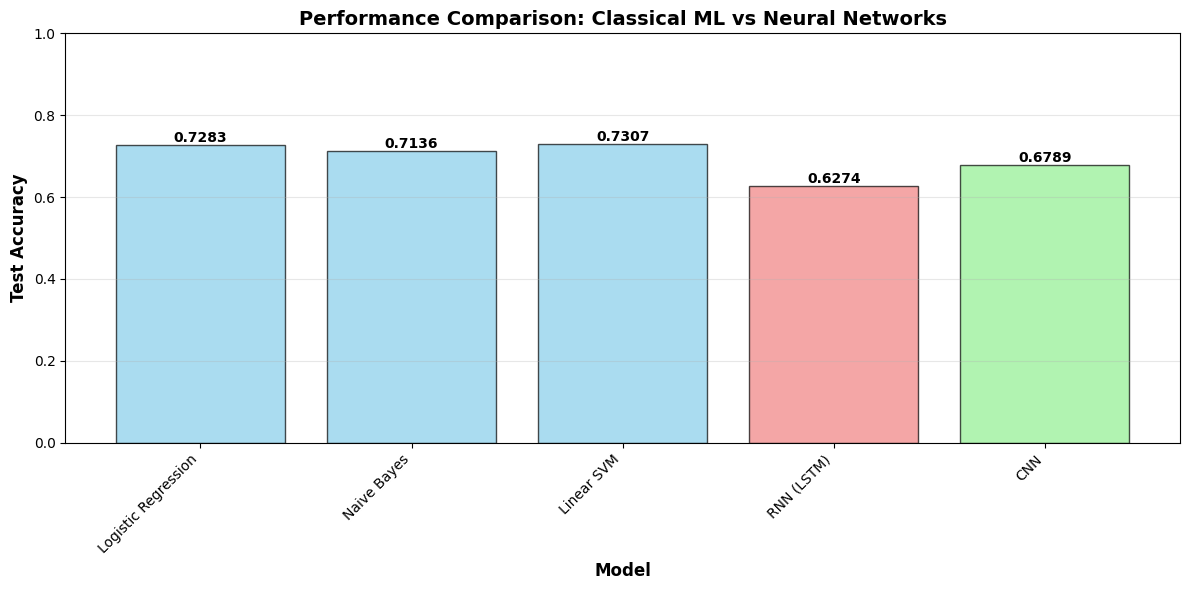

In [39]:
# Visualize comparison
plt.figure(figsize=(12, 6))

models = list(all_results.keys())
accuracies = list(all_results.values())
colors = ['skyblue']*3 + ['lightcoral', 'lightgreen']  # Different colors for classical vs neural

bars = plt.bar(models, accuracies, color=colors, edgecolor='black', alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=12, fontweight='bold')
plt.title('Performance Comparison: Classical ML vs Neural Networks', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

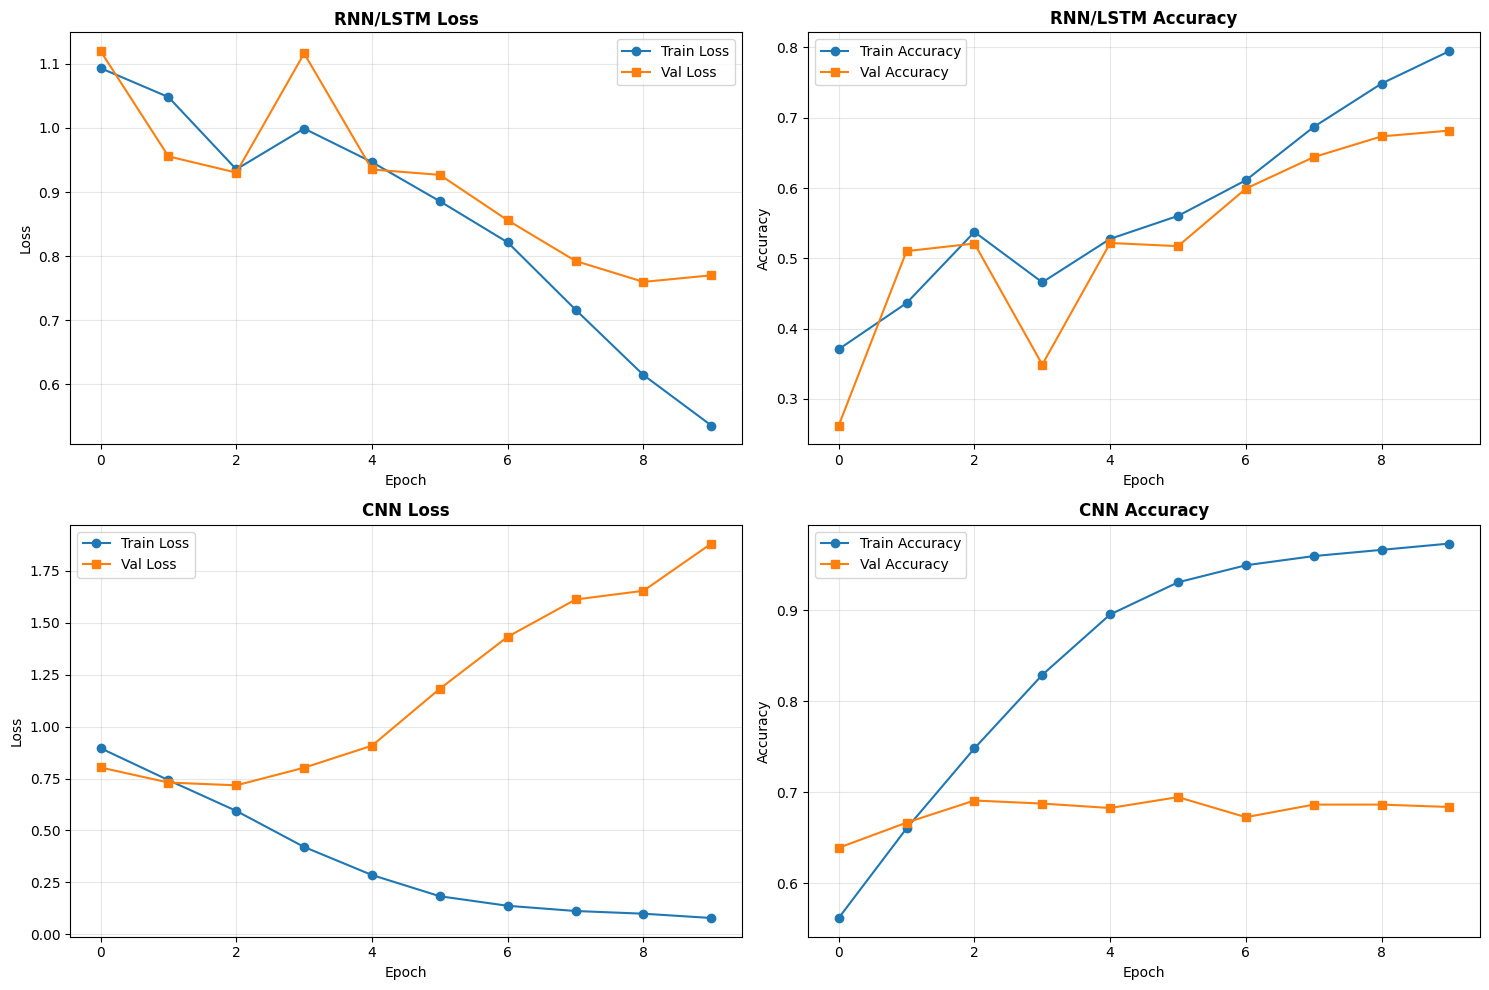

In [40]:
# Plot training history for neural models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RNN Loss
axes[0, 0].plot(rnn_train_losses, label='Train Loss', marker='o')
axes[0, 0].plot(rnn_val_losses, label='Val Loss', marker='s')
axes[0, 0].set_title('RNN/LSTM Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# RNN Accuracy
axes[0, 1].plot(rnn_train_accs, label='Train Accuracy', marker='o')
axes[0, 1].plot(rnn_val_accs, label='Val Accuracy', marker='s')
axes[0, 1].set_title('RNN/LSTM Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# CNN Loss
axes[1, 0].plot(cnn_train_losses, label='Train Loss', marker='o')
axes[1, 0].plot(cnn_val_losses, label='Val Loss', marker='s')
axes[1, 0].set_title('CNN Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# CNN Accuracy
axes[1, 1].plot(cnn_train_accs, label='Train Accuracy', marker='o')
axes[1, 1].plot(cnn_val_accs, label='Val Accuracy', marker='s')
axes[1, 1].set_title('CNN Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

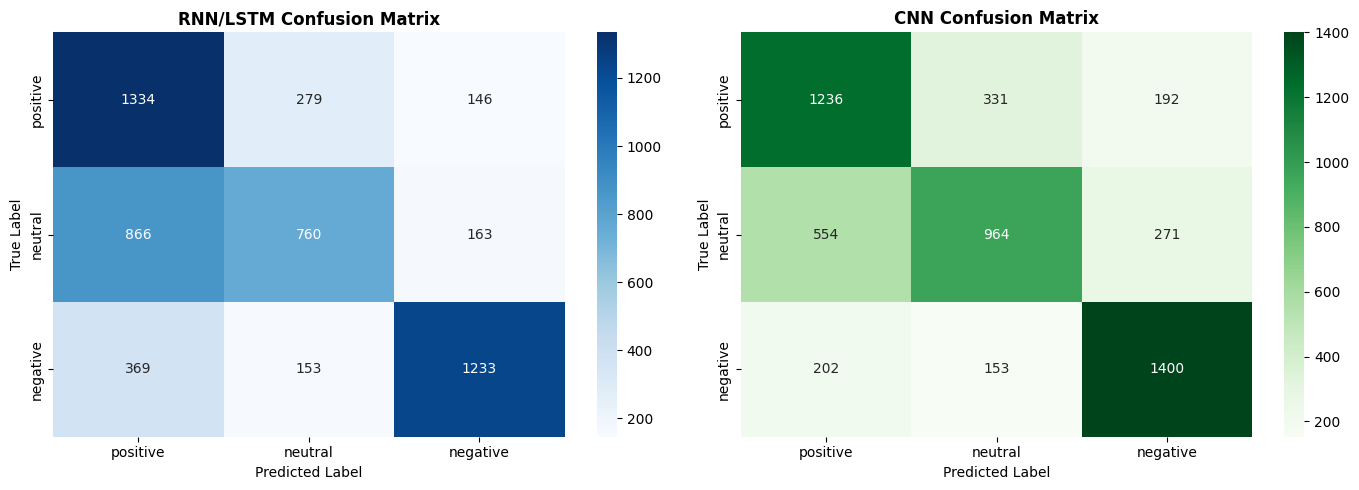

In [41]:
# Confusion matrices for neural models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RNN confusion matrix
cm_rnn = confusion_matrix(rnn_labels, rnn_preds)
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, ax=axes[0])
axes[0].set_title('RNN/LSTM Confusion Matrix', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# CNN confusion matrix
cm_cnn = confusion_matrix(cnn_labels, cnn_preds)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_names, yticklabels=label_names, ax=axes[1])
axes[1].set_title('CNN Confusion Matrix', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 7. Key Insights & Comparison

### Classical ML (TF-IDF + Classifiers)
**Pros:**
- Fast training and inference
- Low computational requirements
- Interpretable (feature importance)
- Good baseline performance

**Cons:**
- Ignores word order (bag-of-words)
- Cannot capture long-range dependencies
- Limited semantic understanding
- Fixed-length feature vectors

### RNN/LSTM
**Pros:**
- Processes sequences step-by-step
- Captures temporal relationships
- Handles variable-length input
- Maintains context via hidden states
- Good for long-range dependencies

**Cons:**
- Sequential processing (slower)
- Vanishing/exploding gradients (mitigated by LSTM)
- More parameters to train

### CNN
**Pros:**
- Parallel processing (faster than RNN)
- Captures local patterns (n-grams)
- Fewer parameters than LSTM
- Effective for classification tasks

**Cons:**
- Limited global context
- Fixed kernel sizes
- May miss long-range dependencies

### When to Use Each?
- **Classical ML**: Quick baseline, limited data, need interpretability
- **RNN/LSTM**: Long documents, need full sequential context, sequence generation
- **CNN**: Fast classification, local patterns important, shorter texts

## 8. Test on New Examples

In [42]:
def predict_sentiment(text, model, model_name, vocab, device):
    """Predict sentiment for a given text using neural models"""
    model.eval()

    # Preprocess
    encoded = vocab.encode(text)
    tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        output = model(tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()

    print(f"\n{model_name} Prediction:")
    print(f"Text: {text}")
    print(f"Sentiment: {label_names[predicted_class]} (confidence: {probabilities[predicted_class]:.4f})")
    print(f"Class probabilities:")
    for i, name in enumerate(label_names):
        print(f"  {name}: {probabilities[i]:.4f}")

# Test examples
test_examples = [
    test_texts[0],
    test_texts[10],
    test_texts[20]
]

for example in test_examples:
    print("\n" + "="*80)
    predict_sentiment(example, rnn_model, "RNN/LSTM", vocab, device)
    predict_sentiment(example, cnn_model, "CNN", vocab, device)



RNN/LSTM Prediction:
Text: ah su rahama za axha madara sa lemu fah mudai deja mn muna tchikin sa alhmdllh allah ya karbi ibadumu yakuma yafe mana kurakurai ameen barka da charuwa ️
Sentiment: negative (confidence: 0.9616)
Class probabilities:
  positive: 0.0340
  neutral: 0.0045
  negative: 0.9616

CNN Prediction:
Text: ah su rahama za axha madara sa lemu fah mudai deja mn muna tchikin sa alhmdllh allah ya karbi ibadumu yakuma yafe mana kurakurai ameen barka da charuwa ️
Sentiment: negative (confidence: 1.0000)
Class probabilities:
  positive: 0.0000
  neutral: 0.0000
  negative: 1.0000


RNN/LSTM Prediction:
Text: uhmmm allah allah ne lokaci baqone rana da lokaci sunanan zuwa koubajima kou badade koumuna raye koubama raye zamubada rayuwarmu muuuuu domin addininmu zamukare martavan addininmu dayardan aubangijin adalci
Sentiment: negative (confidence: 0.8750)
Class probabilities:
  positive: 0.0989
  neutral: 0.0261
  negative: 0.8750

CNN Prediction:
Text: uhmmm allah allah ne lokaci

## Summary

This notebook demonstrated three approaches to text classification:

1. **Classical ML** provides a strong baseline using TF-IDF features but ignores word order
2. **RNN/LSTM** captures sequential patterns and long-range dependencies through recurrent connections
3. **CNN** efficiently extracts local n-gram features using convolution filters

**Key Takeaways:**
- Classical ML is fast but limited by bag-of-words assumption
- RNNs excel at modeling sequential dependencies but are computationally expensive
- CNNs offer a good balance between performance and efficiency for text classification
- The choice depends on your specific task, data, and computational constraints

**Implementation Notes:**
- PyTorch provides flexible model building with custom architectures
- DataLoader handles batching and padding efficiently
- GPU acceleration significantly speeds up training
- Proper evaluation metrics are crucial for understanding model performance

**Next Steps:**
- Try bidirectional LSTM (Bi-LSTM) for better context capture
- Experiment with multiple CNN filter sizes simultaneously
- Use pre-trained embeddings (Word2Vec, GloVe, FastText)
- Explore hybrid models (CNN + LSTM)
- Consider attention mechanisms
- Try transformer-based models (BERT, RoBERTa) for state-of-the-art performance (Next Lecture!)

# Further Exploration

**For more example on understanding and implementing sequence classification, check this repository:**

```https://github.com/bentrevett/pytorch-sentiment-analysis```